# Example to generate mobile traffic samples

This is the workflow we utilized on Section 6 of the paper. 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import pomegranate

np.random.seed(0)

## Functions

In [2]:
"""
Inverse function of the powerlaw that connects 
session duration and traffic volume
"""

def func_invpowerlaw(x,a,b):
    return ((x)/a)**(1/b)      

## Load data

In [3]:
##Shares of sessions and traffic across apps 
df_sessions_day = pd.read_csv('data/sessions_share.csv')

##Coeffcients for arrival rates for different types of antennas
df_arrival_coefs = pd.read_csv('data/arrival_coefs.csv')

##Coefficients for the mixture models that represent session-level traffic
df_pdf_coefs = pd.read_csv('data/pdf_coefs.csv')

##Coefficients for the powerlaw that related session duration to session traffic
df_powerlaw_coefs = pd.read_csv('data/duration_coefs.csv')

## Generating sessions for a set of antennas

In [51]:
"""
Configuring the simulation
On this example, we have 10 different antennas with different expected loads,
going across 10 days, on a per minute basis. 
We choose only peak hours to generate the samples.
"""
n_antennas = 2
antennas = np.arange(0,n_antennas,1)
decile_list = [1,0.8,0.7,0.6,0.7,0.6,0.5,0.9,0.5,0.6]
n_days = 10
days = np.arange(1,n_days+1,1)
hours = np.arange(8,22,1)
minutes = np.arange(0,60,1)

In [52]:
"""
A df that will hold all the respective minutes 
"""
df_dayhourminute = pd.DataFrame(columns=['day','hour','minute','moment'])
for day in days:
    for hour in hours:
        for minute in minutes:
            d = {'day':[day],
                'hour':[hour],
                'minute':[minute],
                'moment':['peak'],}
            df_dayhourminute = pd.concat([df_dayhourminute,pd.DataFrame(d)])

df_dayhourminute = df_dayhourminute.reset_index(drop=True)

total_minutes = len(days)*len(hours)*len(minutes) #number of minutes for one antenna during the period
peak_minutes = int(total_minutes)

In [53]:
df_traffic_duration = pd.DataFrame(columns=['antenna', 'service', 'traffic', 'duration', 'day', 'hour', 'minute'])

for antenna in antennas:
    ##Now we will generate how many samples are seen at each minute for that antenna
    decile = decile_list[antenna]
    df_antenna_arrival = df_arrival_coefs.loc[(df_arrival_coefs.peak=='peak') & (df_arrival_coefs.decile==decile)].reset_index(drop=True)
    mu = df_antenna_arrival.loc[0,'loc']
    sigma = df_antenna_arrival.loc[0,'scale']
    peak_arrivals_perminute = stats.norm(mu,sigma).rvs(peak_minutes,random_state=42)

    for i in range(len(peak_arrivals_perminute)):
        peak_arrivals_perminute[i] = np.round(peak_arrivals_perminute[i])

    df_traffic_duration_temp = pd.DataFrame(columns=['antenna','service','traffic','duration'])
    for app in df_pdf_coefs.app.unique():
        ##Filtering the app and getting the share of sessions
        share = df_sessions_day.loc[df_sessions_day.app==app,'sessions%'].iloc[0]
        desired_samples_app = int(np.round(peak_arrivals_perminute.sum()*share/100))+1
        print(antenna,app,desired_samples_app)    

        ##PDF coefs 
        pdf_coefs = df_pdf_coefs.loc[df_pdf_coefs.app==app].reset_index(drop=True)
        if pdf_coefs.loc[0,'u_0']=='-':
            pdf_coefs['u_g'] = pdf_coefs['u_g'].astype(float)
            pdf_coefs['s_g'] = pdf_coefs['s_g'].astype(float)     
            model = pomegranate.NormalDistribution(pdf_coefs.loc[0,'u_g'],pdf_coefs.loc[0,'s_g'])
        elif pdf_coefs.loc[0,'u_1']=='-':
            pdf_coefs['u_g'] = pdf_coefs['u_g'].astype(float)
            pdf_coefs['s_g'] = pdf_coefs['s_g'].astype(float)    
            pdf_coefs['u_0'] = pdf_coefs['u_0'].astype(float)
            pdf_coefs['s_0'] = pdf_coefs['s_0'].astype(float)
            pdf_coefs['w_0'] = pdf_coefs['w_0'].astype(float)
            d_g = pomegranate.NormalDistribution(pdf_coefs.loc[0,'u_g'],pdf_coefs.loc[0,'s_g'])
            d0 = pomegranate.NormalDistribution(pdf_coefs.loc[0,'u_0'],pdf_coefs.loc[0,'s_0'])
            model = pomegranate.GeneralMixtureModel([d_g, d0], weights=[1,pdf_coefs.loc[0,'w_0']])
        elif pdf_coefs.loc[0,'u_2']=='-':
            pdf_coefs['u_g'] = pdf_coefs['u_g'].astype(float)
            pdf_coefs['s_g'] = pdf_coefs['s_g'].astype(float)     
            pdf_coefs['u_0'] = pdf_coefs['u_0'].astype(float)
            pdf_coefs['s_0'] = pdf_coefs['s_0'].astype(float)
            pdf_coefs['w_0'] = pdf_coefs['w_0'].astype(float)
            pdf_coefs['u_1'] = pdf_coefs['u_1'].astype(float)
            pdf_coefs['s_1'] = pdf_coefs['s_1'].astype(float)
            pdf_coefs['w_1'] = pdf_coefs['w_1'].astype(float)
            d_g = pomegranate.NormalDistribution(pdf_coefs.loc[0,'u_g'],pdf_coefs.loc[0,'s_g'])
            d0 = pomegranate.NormalDistribution(pdf_coefs.loc[0,'u_0'],pdf_coefs.loc[0,'s_0'])
            d1 = pomegranate.NormalDistribution(pdf_coefs.loc[0,'u_1'],pdf_coefs.loc[0,'s_1'])
            model = pomegranate.GeneralMixtureModel([d_g, d0, d1], weights=[1,pdf_coefs.loc[0,'w_0'],pdf_coefs.loc[0,'w_1']])
        else: 
            pdf_coefs['u_g'] = pdf_coefs['u_g'].astype(float)
            pdf_coefs['s_g'] = pdf_coefs['s_g'].astype(float)     
            pdf_coefs['u_0'] = pdf_coefs['u_0'].astype(float)
            pdf_coefs['s_0'] = pdf_coefs['s_0'].astype(float)
            pdf_coefs['w_0'] = pdf_coefs['w_0'].astype(float)
            pdf_coefs['u_1'] = pdf_coefs['u_1'].astype(float)
            pdf_coefs['s_1'] = pdf_coefs['s_1'].astype(float)
            pdf_coefs['w_1'] = pdf_coefs['w_1'].astype(float)    
            pdf_coefs['u_2'] = pdf_coefs['u_2'].astype(float)
            pdf_coefs['s_2'] = pdf_coefs['s_2'].astype(float)
            pdf_coefs['w_2'] = pdf_coefs['w_2'].astype(float)        
            d_g = pomegranate.NormalDistribution(pdf_coefs.loc[0,'u_g'],pdf_coefs.loc[0,'s_g'])
            d0 = pomegranate.NormalDistribution(pdf_coefs.loc[0,'u_0'],pdf_coefs.loc[0,'s_0'])
            d1 = pomegranate.NormalDistribution(pdf_coefs.loc[0,'u_1'],pdf_coefs.loc[0,'s_1'])
            d2 = pomegranate.NormalDistribution(pdf_coefs.loc[0,'u_2'],pdf_coefs.loc[0,'s_2'])
            model = pomegranate.GeneralMixtureModel([d_g, d0, d1, d2], weights=[1,pdf_coefs.loc[0,'w_0'],pdf_coefs.loc[0,'w_1'],pdf_coefs.loc[0,'w_2']])    
                
        #most critical part, generating samples based on the share
        pdf_samples = model.sample(desired_samples_app)
        pdf_samples = 10**pdf_samples
        
        """Duration"""
        coefs = df_powerlaw_coefs.loc[df_powerlaw_coefs.app==app].reset_index(drop=True)
        durations = np.nan_to_num(x=func_invpowerlaw(pdf_samples,coefs.loc[0,'a'],coefs.loc[0,'b']),nan=5)
        
        temp = pd.DataFrame({'antenna':antenna,'service':app,'traffic':pdf_samples,'duration':durations})
        df_traffic_duration_temp = pd.concat([df_traffic_duration_temp,temp])
        
    df_traffic_duration_temp = df_traffic_duration_temp.sample(frac=1)
    df_traffic_duration_temp = df_traffic_duration_temp.reset_index(drop=True)

    ##Samples were assigned randomly before, so now we need to put them on minutes 
    df_traffic_duration_temp['day'] = 'tbd'
    df_traffic_duration_temp['hour'] = 'tbd'
    df_traffic_duration_temp['minute'] = 'tbd'

    cumsum_arrivals = np.cumsum(peak_arrivals_perminute)

    for i in range(len(cumsum_arrivals)):
        day = df_dayhourminute.loc[i,'day']
        hour = df_dayhourminute.loc[i,'hour']
        minute = df_dayhourminute.loc[i,'minute']
        if i == 0:
            df_traffic_duration_temp.loc[0:cumsum_arrivals[0]-1,'day'] = day
            df_traffic_duration_temp.loc[0:cumsum_arrivals[0]-1,'hour'] = hour
            df_traffic_duration_temp.loc[0:cumsum_arrivals[0]-1,'minute'] = minute
        else:
            df_traffic_duration_temp.loc[cumsum_arrivals[i-1]:cumsum_arrivals[i]-1,'day'] = day
            df_traffic_duration_temp.loc[cumsum_arrivals[i-1]:cumsum_arrivals[i]-1,'hour'] = hour
            df_traffic_duration_temp.loc[cumsum_arrivals[i-1]:cumsum_arrivals[i]-1,'minute'] = minute

    df_traffic_duration_temp = df_traffic_duration_temp.loc[df_traffic_duration_temp.day!='tbd']      

    df_traffic_duration = pd.concat([df_traffic_duration,df_traffic_duration_temp])

0 Amazon 6342
0 Apple iCloud 8947
0 Clash of Clans 1179
0 Deezer 7422
0 Facebook 219167
0 Facebook Live 8112
0 Facebook Messenger 1467
0 Generic Clothes 5258
0 Gmail 2997
0 Google Docs 407
0 Google Maps 15958
0 Google Meet 1434
0 Instagram (main) 79834
0 Instagram (videos) 39559
0 LinkedIn 2768
0 Microsoft Mail 621
0 Netflix 17994
0 Pokemon GO 266
0 SnapChat 106262
0 Spotify 6681
0 Telegram 2682
0 Twitch 5276
0 Twitter (main) 6413
0 Twitter (videos) 1905
0 Uber 457
0 Waze 9274
0 WhatsApp 6137
0 Wikipedia 385
0 Yahoo 2014
0 Youtube 29555
1 Amazon 2287
1 Apple iCloud 3226
1 Clash of Clans 426
1 Deezer 2676
1 Facebook 79001
1 Facebook Live 2925
1 Facebook Messenger 530
1 Generic Clothes 1896
1 Gmail 1081
1 Google Docs 147
1 Google Maps 5753
1 Google Meet 518
1 Instagram (main) 28777
1 Instagram (videos) 14260
1 LinkedIn 998
1 Microsoft Mail 225
1 Netflix 6487
1 Pokemon GO 97
1 SnapChat 38303
1 Spotify 2409
1 Telegram 967
1 Twitch 1902
1 Twitter (main) 2312
1 Twitter (videos) 687
1 Uber 16

## Visualizing a few of the generated samples for each app 

One important thing to note is that the generated random traffic samples $x$ are the exponent of $10^{x}$, i.e. an $x=6$ means the traffic consumed by this random session is $10^{6}$ bytes, which meand the Normal distributions declared here are actually log-normal distributions

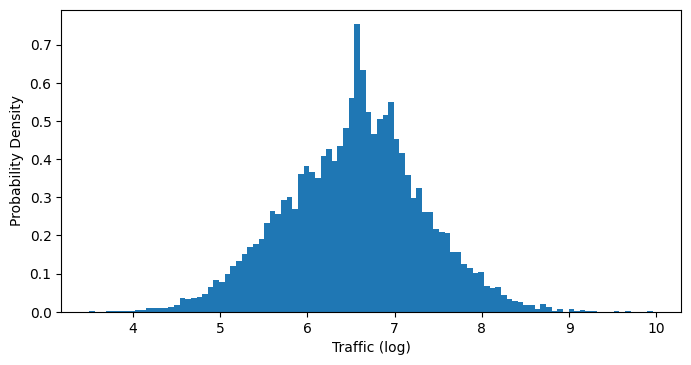

In [57]:
plt.figure(figsize=(8,4),dpi=100)

plt.hist(np.log10(df_traffic_duration.loc[df_traffic_duration.service=='Deezer','traffic']).to_numpy(),bins=100,density=True)

plt.ylabel('Probability Density')
plt.xlabel('Traffic (log)')

plt.show()

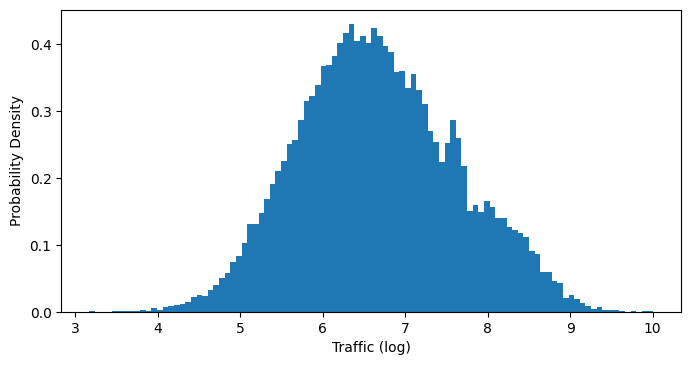

In [58]:
plt.figure(figsize=(8,4),dpi=100)

plt.hist(np.log10(df_traffic_duration.loc[df_traffic_duration.service=='Netflix','traffic']).to_numpy(),bins=100,density=True)

plt.ylabel('Probability Density')
plt.xlabel('Traffic (log)')

plt.show()

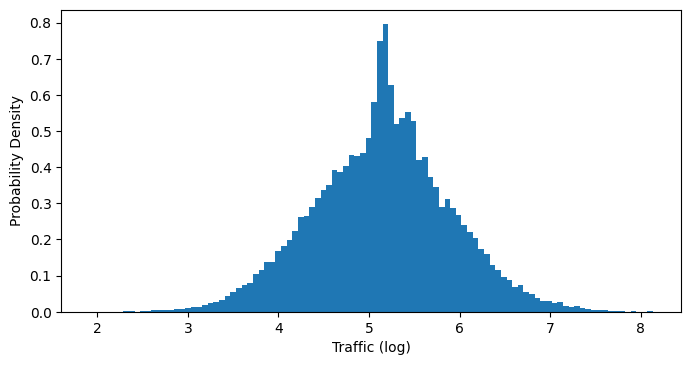

In [59]:
plt.figure(figsize=(8,4),dpi=100)

plt.hist(np.log10(df_traffic_duration.loc[df_traffic_duration.service=='Youtube','traffic']).to_numpy(),bins=100,density=True)

plt.ylabel('Probability Density')
plt.xlabel('Traffic (log)')

plt.show()